In [5]:
include("rowenhorst_tauchen.jl") # include discretization functions (make sure it is in your working directory)

using Parameters, Plots, LinearAlgebra, Interpolations, BenchmarkTools

Household = @with_kw (apoints = 500, #asset grid
    amax = 50,  # asset max
    beta = 0.98, # discount factor
    alpha = 0.11, # capital share
    deprec = 0.025, # depreciation rate
    gamma = 1, # elasticity of substitution
    bc = 0, # borrowing constraint (must be weakly negative)
    rho = 0.966,  # autocorr of income process
    num_states = 7, # number of states for income process
    sd = 0.13, # stand. dev. of deviation process
    mean = 0, # mean of income process
    uncond_sd = 0.13/sqrt(1-rho^2), # unconditional sd
    transition_matrix = rowenhorst(mean, uncond_sd, rho, num_states)[1], # transition matrix
    ygrid = rowenhorst(mean, uncond_sd, rho, num_states)[2], # grid for income process
    Amat = setgrids(bc, apoints, amax, num_states, ygrid)[1], # asset grid
    Ymat = setgrids(bc, apoints, amax, num_states, ygrid)[2], # income grid
    phi = 0.8, # disutility factor
    frisch = 0.5) # frisch elasticity for labor supply 


function setgrids(bc, apoints, amax, num_states, ygrid)
    Amat = [i for i in range(bc, length = apoints, stop= amax), j in 1:num_states]
    Ymat = [j for i = 1:apoints, j in ygrid]
    return Amat, Ymat
end

# these grids are more dense on the lower portion of the asset grid where the policy functions have more curvature

function setunevengrids(bc, apoints, amax, num_states, ygrid)
    unevengrid = range(log(1/(-bc + 1)), length = apoints, stop = -log(amax + 1))
    unevengrid = exp.(-unevengrid) .- 1
    Amat = [i for i in unevengrid, j in 1:num_states]
    Ymat = [j for i = 1:apoints, j in ygrid]
    return Amat, Ymat
end
    
hh = Household()

(apoints = 500, amax = 50, beta = 0.98, alpha = 0.11, deprec = 0.025, gamma = 1, bc = 0, rho = 0.966, num_states = 7, sd = 0.13, mean = 0, uncond_sd = 0.5028195291614176, transition_matrix = [0.9022379843199956 0.09361981119088468 … 8.374316586000039e-9 2.4137569000000128e-11; 0.015603301865147443 0.9035872016735433 … 4.0355125541400147e-7 1.3957194310000061e-9; … ; 1.3957194310000061e-9 4.0355125541400147e-7 … 0.9035872016735433 0.015603301865147443; 2.4137569000000125e-11 8.374316586000037e-9 … 0.09361981119088467 0.9022379843199955], ygrid = [0.25738376293233367, 0.38804396244888767, 0.5850334732755494, 0.8820241982193845, 1.3297814941917474, 2.0048416198384222, 3.022594266947119], Amat = [0.0 0.0 … 0.0 0.0; 0.10020040080160321 0.10020040080160321 … 0.10020040080160321 0.10020040080160321; … ; 49.899799599198396 49.899799599198396 … 49.899799599198396 49.899799599198396; 50.0 50.0 … 50.0 50.0], Ymat = [0.25738376293233367 0.38804396244888767 … 2.0048416198384222 3.022594266947119; 0

In [6]:
function u(c, gamma)
    if gamma == 1
        return log.(c)
    else
        return @. c^(1-gamma)/(1-gamma) 
    end
end

function c(k,knext,w,y,r,deprec)
    return @. (1+r)*k + w*y - knext
end

function utility_matrix(hh; w = 1, r = 0.01)
   @unpack apoints, deprec, gamma, num_states, Amat, ygrid =  hh
    
    consumption_matrix = zeros(apoints, apoints, num_states)
    utility_matrix = similar(consumption_matrix)
    
    for (k_ind, k) in enumerate(Amat[:,1])
        for (y_ind, y) in enumerate(ygrid)
            consumption_matrix[k_ind,:,y_ind] = c(k, Amat[:,1], w, y, r, deprec)
        end
    end
    
    mask = consumption_matrix.<0
    consumption_matrix[mask] .= 0 # debugging for log, otherwise throws error for negative numbers
    utility_matrix = u(consumption_matrix, gamma)
    utility_matrix[mask] .= -Inf
    
    return utility_matrix
end

function bellman(hh; utility_matrix, v, w = 1, r = 0.01)
    @unpack apoints, deprec, gamma, num_states, Amat, ygrid, beta, transition_matrix =  hh

    vnext = similar(v)
    policyfun = similar(v)

    for kind = 1:apoints
        for yind = 1:num_states

            max, maxind = findmax(utility_matrix[kind,:,yind] + beta.*(v[:,:]*transition_matrix[yind,:]))

            vnext[kind,yind] = max
            policyfun[kind, yind] = maxind
        end
    end

    return vnext, policyfun
end

function iterate_bellman(hh; v, tol = 1e-6, maxiter = 1000)
    util = utility_matrix(hh)
    
    iter = 0
    for i = 1:maxiter
        vnext, _ = bellman(hh; utility_matrix = util, v = v)
        if norm(vnext - v, Inf) < tol 
            println("bellman iteration successful!")
            println("iterations = $iter")
            return bellman(hh; utility_matrix = util, v = vnext)
        else
            v = vnext
            iter = iter +1
        end
    end
    
    error("no policy function convergence!")
end

@time v, policyfun = iterate_bellman(hh, v = zeros(500,7))


bellman iteration successful!
iterations = 577
 31.979208 seconds (16.34 M allocations: 84.950 GiB, 14.15% gc time)


([-29.278605313349885 -21.55990339338129 … 9.843437244076872 18.297470845378374; -28.947004537969093 -21.328155850741158 … 9.907606801390402 18.348108191404407; … ; 16.005702832751957 18.36424709195585 … 32.470546719612095 37.57863418017504; 16.055727154549572 18.411685696767996 … 32.50513213512439 37.60778446046877], [1.0 1.0 … 5.0 11.0; 1.0 1.0 … 6.0 12.0; … ; 486.0 487.0 … 495.0 500.0; 487.0 488.0 … 496.0 500.0])

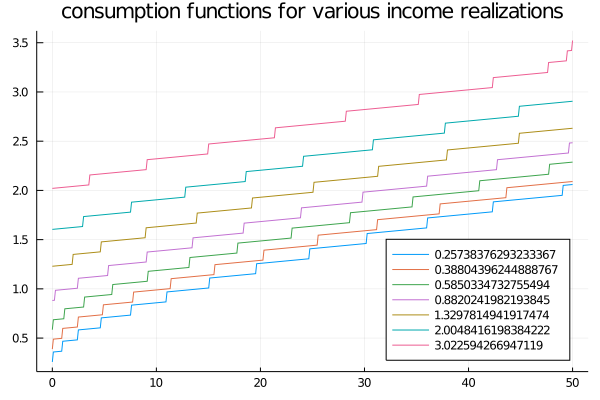

In [18]:
@unpack Amat, num_states, ygrid = hh

r = 0.01; w = 1;

cpolicy = similar(Amat)

for i = 1:num_states
    cpolicy[:,i] = (1+r).*Amat[:,1] .+ w.*ygrid[i] .- Amat[Int.(policyfun[:,i])]
end


p = plot()
for i = 1:num_states
    plot!(p, Amat[:,1],cpolicy[:,i], label = ygrid[i], legend = :bottomright)
end
plot(p, title = "consumption functions for various income realizations")



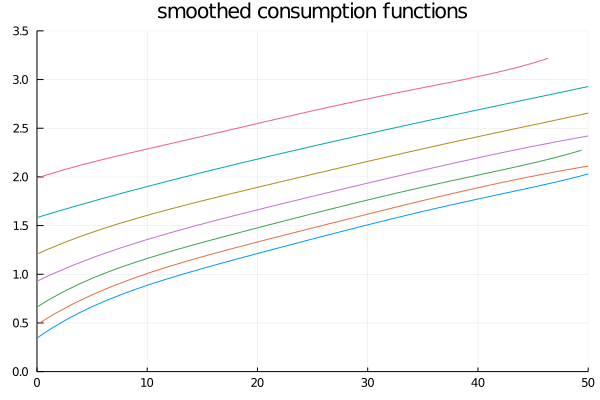

In [28]:
using Polynomials

p = plot()
for i = 1:num_states
    plot!(Polynomials.fit(Amat[:,1], cpolicy[:,i], 5), legend = false)
end

plot(p, title = "smoothed consumption functions", xlims = (0,50), ylims = (0,3.5))

#TODO
## extend to labour choice
## EGM with labour choice
